# Getting started with Acoular - Part 3
> How to use Acoular - simple example with 64 microphone array and three sources, time domain beamforming
- tags: [time domain beamforming]
- author: Ennes Sarradj
- comments: true

This is the third and final in a series of three blog posts about the basic use of Acoular. It assumes that you already have read the first two posts and continues by explaining additional concepts to be used with time domain methods.

Acoular is a Python library that processes multichannel data (up to a few hundred channels) from acoustic measurements with a microphone array. The focus of the processing is on the construction of a map of acoustic sources. This is somewhat similar to taking an acoustic photograph of some sound sources.

To continue, we do the same set up as in [Part 1](../../../2021/04/01/getstart1.html). However, as we are setting out to do some signal processing in time domain, we define only `TimeSamples`, `MicGeom`, `RectGrid` and `SteeringVector` objects but no `PowerSpectra` or `BeamformerBase`.


In [1]:
import acoular
ts = acoular.TimeSamples( name="three_sources.h5" )
mg = acoular.MicGeom( from_file="array_64.xml" )
rg = acoular.RectGrid( x_min=-0.2, x_max=0.2,
                       y_min=-0.2, y_max=0.2,
                       z=0.3, increment=0.01 )
st = acoular.SteeringVector( grid=rg, mics=mg )

For processing in time domain in Acoular, one may set up "chains" of processing blocks. This is very flexible and allows for easy implementation of new algorithms or algorithmic steps. Each of the blocks acts on all channels at once. Input and output may have different numbers of channels. 

For our task we set up the following processing chain:
1. __data intake__ from file (`TimeSamples`, same as before)
2. __beamforming__. In the time domain this amounts to different delays that have to be applied to all channels and for all grid points, and a sum for each of the grid points. This is also known as delay-and-sum.
3. __band pass filtering__ (the time history for each point in the map is filtered). We could skip that step in principle, but it is nice to compare the result to what we got in Parts 1 and 2 from frequency domain processing, where we did a similar approach to band pass filtering.
4. __power estimation__ (just the square, nothing else), so that we can compute levels
5. __linear average__ over consecutive blocks in time which makes it possible to have not one image for every sample in time, which is huge amount of (mostly useless) data, but just enough data for some images

Each object in the processing chain is connected to its predecessor via the `source` parameter:

In [2]:
bt = acoular.BeamformerTime( source=ts, steer=st )
ft = acoular.FiltOctave( source=bt, band=8000, fraction='Third octave' )
pt = acoular.TimePower( source=ft )
avgt = acoular.TimeAverage( source=pt, naverage=6400 )

And again: lazy evaluation, nothing is computed yet.

Only asking for the result will initiate computing. Although this is not used in this example, it should be mentioned that the architecture allows for endless data processing from a stream of input data. To this end it is possible to replace the `TimeSamples` object that reads the data not from a file, but from hardware.

Different to the frequency domain processing, the result is not computed in one go, but in _blocks_ of data. These blocks have a variable length that can be defined as argument of the `result` function each of the processing blocks have. Note that this function is actually a Python [generator](https://wiki.python.org/moin/Generators), that yields a number of results we have to iterate over. This helps if one wants to process large amounts of data that do not fit into the memory at once. Iteration means we can use it in `for` loop and get a new data block each time we run through the loop.

In our example we use the loop in a Python list comprehension statement. That means we collect all blocks into a list. In our case, the blocks have length 1, i.e. one map per block.

In [3]:
res = [r.copy() for r in avgt.result(1)]

The list `res` contains all maps each of which averages over 6400 samples. Now we can plot all of these maps. Because time domain processing sees the map as (number of gridpoints) channels, we have to reshape the maps so that fit the shape of the grid.

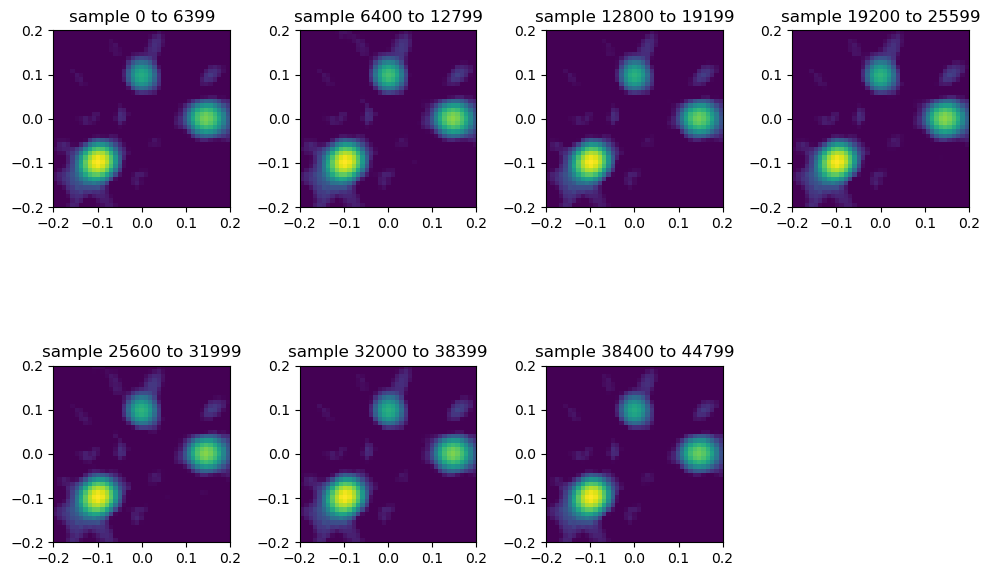

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
for i,r in enumerate(res):
    pm = r[0].reshape(rg.shape)
    Lm = acoular.L_p(pm)
    plt.subplot(2,4,i+1)
    plt.imshow(Lm.T, vmin=Lm.max()-15, origin='lower', extent=rg.extend())
    plt.title('sample %i to %i' % (i*6400,i*6400+6399))
plt.tight_layout();

Because the sources emit a stationary signal, the individual maps do look not much different. The result is also very similar to what we got with the frequency domain beamformer in Part 1.


We can assemble the processing chain also in a different way with positions 2 and 3 exchanged:
1. __data intake__ 
3. __band pass filtering__ 
2. __beamforming__
4. __power estimation__ 
5. __linear average__ 

In this case we have to be careful about the effects of filtering: Because the band pass filter comes also with a frequency dependent delay, this can disturb the work of the beamformer in case that sources are not stationary. To circumvent this, we could use a special filter `FiltFiltOctave` with zero delay. The disavantage of this filter is that the whole time history must be read into the memory, before the first block can be processed by the beamformer. In the present simple example it is not necessary to do this.

We just "rewire" the processing chain. One advantage in this case is that we only have to band pass filter 64 channels (number of microphones) instead of 1641 channels (number of grid points as in the first case.

In [6]:
ft.source = ts
bt.source = ft
pt.source = bt

After the new chain is set up, we can again plot the results. This time we do not use an extra list for all results, but iterate directly over the maps while plotting. Remember that this takes some time.

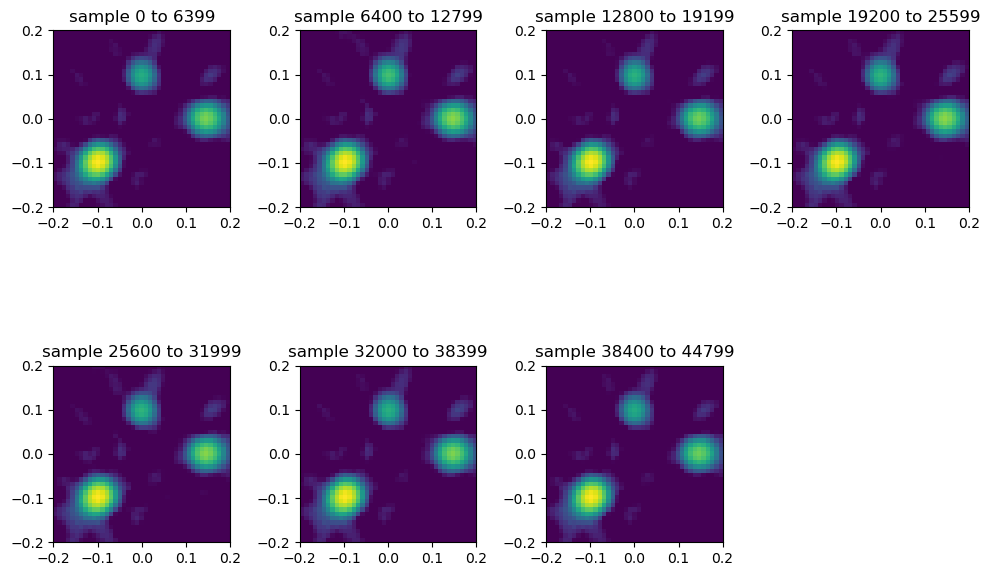

In [7]:
plt.figure(figsize=(10,7))
for i,r in enumerate(avgt.result(1)):
    pm = r[0].reshape(rg.shape)
    Lm = acoular.L_p(pm)
    plt.subplot(2,4,i+1)
    plt.imshow(Lm.T, vmin=Lm.max()-15, origin='lower', extent=rg.extend())
    plt.title('sample %i to %i' % (i*6400,i*6400+6399))
plt.tight_layout();

According to our expectations, the result looks very much the same with this alternative processing chain.

This concludes this series of three blog posts about first steps in Acoular. If you want to know more, look at the [documentation](http://acoular.org) and the examples and the reference you will find there or watch out for new blog posts to come!